In [20]:
# TODO: consider making list of dependencies for TA to install when running this notebook
import sklearn
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Import track data
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']
dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)

# Remove rows duplicated by ignoring some columns
dataset = dataset[~dataset.duplicated()==1]

# Normalize columns having values outside [0, 1]
scaler = MinMaxScaler()
cols_to_normalize = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

# print(dataset)

        acousticness  danceability  duration_ms  energy  explicit  \
0           0.991000         0.598     0.030637  0.2240         0   
1           0.643000         0.852     0.027237  0.5170         0   
2           0.993000         0.647     0.029792  0.1860         0   
3           0.000173         0.730     0.078215  0.7980         0   
4           0.295000         0.704     0.030054  0.7070         1   
...              ...           ...          ...     ...       ...   
174369      0.995000         0.297     0.064549  0.0287         0   
174371      0.995000         0.343     0.037830  0.0165         0   
174375      0.988000         0.316     0.055949  0.0573         0   
174377      0.795000         0.429     0.026209  0.2110         0   
174387      0.920000         0.462     0.044824  0.2400         1   

        instrumentalness       key  liveness  loudness  mode  popularity  \
0               0.000522  0.454545    0.3790  0.741868     0        0.12   
1               0.0

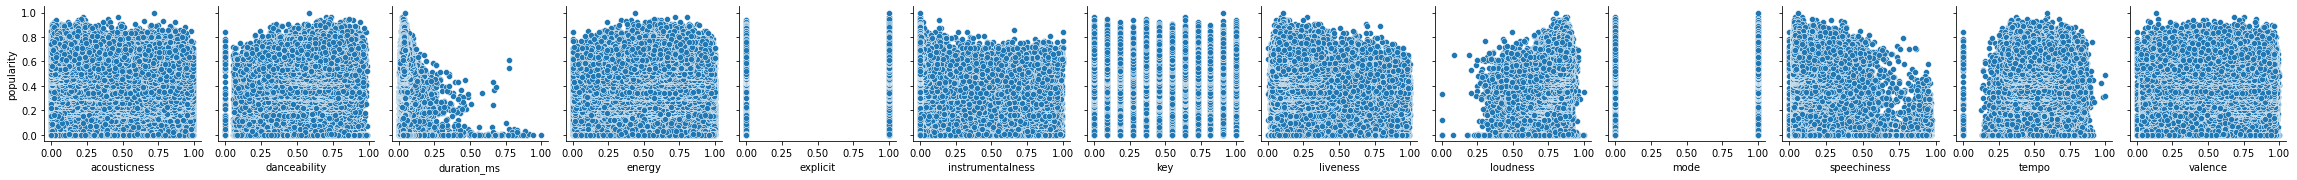

In [39]:
# Data analysis
# pair plots: https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sb

# Pairwise plots between each column in the data set excluding popularity, binary (mode and explicit) and discrete (key) features
pair_plot_data = dataset.drop(columns=['mode', 'explicit', 'key', 'popularity'])
# sb.pairplot(pair_plot_data, corner=True)
# There isn't a lot of direct correlation between any two property of a song

# Correlation between each property and popularity
sb.pairplot(dataset, x_vars=usecols,
    y_vars=['popularity'])
# The proprties we have left do not directly correlate with the popularity of a song

# analyze binary features (mode, explicit)

In [ ]:
# TODO: further preprocessing?

y = dataset.pop('popularity') # popularity is our class to predict
X_headers = list(dataset.columns.values)
X = dataset.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
# Hyperparameter tuning

# Set the parameters by cross-validation
tuned_parameters = [{
    'criterion': ['mse'],
    'max_depth': np.linspace(1, 10, 10, dtype=int),
    'ccp_alpha' : np.linspace(0.0003, 0.0006, 6),
    'max_leaf_nodes': np.linspace(256, 324, 35, dtype=int)
    }]

# Available regression metrics are given here: https://scikit-learn.org/stable/modules/classes.html#regression-metrics
scores = ['r2_score', # 'neg_mean_squared_error', 'max_error'] 

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        tree.DecisionTreeRegressor(), tuned_parameters, scoring=score
    )
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()


# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 260}

Grid scores on development set:

-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 256}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 258}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 260}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 262}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 264}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 266}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 268}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0003, 'criterion': 'mse',

-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 290}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 292}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 294}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 296}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 298}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 300}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 302}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 304}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_depth': 1, 'max_leaf_nodes': 306}
-0.039 (+/-0.001) for {'ccp_alpha': 0.0006, 'criterion': 'mse', 'max_dept

ValueError: continuous is not supported

In [12]:
# Report grid search results
kwargs = {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 260}
clf = tree.DecisionTreeRegressor(**kwargs)
clf.fit(X_train, y_train)
print(f"r2: {clf.score(X_test, y_test)}")
print(f"mse: {mean_squared_error(y_test, clf.predict(X_test), squared=True)}")


r2: 0.34639467984968664
mse: 0.031165492448364918


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

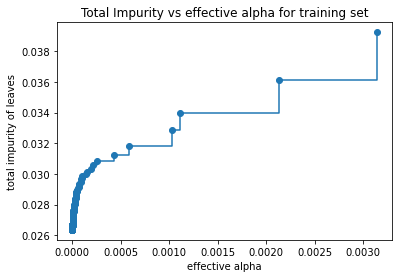

In [3]:
criteria = ["mse", "friedman_mse"] # didn't make a big difference
max_depth = 9 # found to result in best accuracy TODO: test over a range

clf = tree.DecisionTreeRegressor(criterion="mse", max_depth=max_depth)
#     clf = clf.fit(X_train, y_train)

# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# print(cross_val_score(clf, X_train, y_train, cv=cv))


# Following a tutorial on Cost Complexity Pruning https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [24]:
# generating different classifiers having different ccp_alpha values
# WARNING: this takes a very long time to run! Below, ccp_alphas is pruned to cut down on computation time.
# clfs = []
# NUM_CCP_ALPHAS = 5
# ccp_alphas = ccp_alphas[:NUM_CCP_ALPHAS]
# for ccp_alpha in ccp_alphas:   
#     print(f"ccp_alpha: {ccp_alpha}")
#     clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

# search for optimal ccp_alpha (seems to be somewhere in range 10**-4 to 10**-6)
# 0 (99%/-0.6%), 0.0005 (34.3%/33.4%), 0.0000005 (88.3%/5.49%)
for x in range(2,7):
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=10**-x)
    clf.fit(X_train, y_train)
    print(f"alpha: {10**-x}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


max_leaf_node: 4
0.28523737860475695
0.28021176508181433
max_leaf_node: 9
0.357203848141723
0.3526979405513757
max_leaf_node: 16
0.3785877522877038
0.3736002280191959
max_leaf_node: 25
0.391856046922213
0.38550156590622287
max_leaf_node: 36
0.4015362298723337
0.39386074386211245
max_leaf_node: 49
0.4094787231480488
0.40108637201051067
max_leaf_node: 64
0.4162361283040743
0.4058670929998296
max_leaf_node: 81
0.42201371953216016
0.4098364377815119
max_leaf_node: 100
0.42701245844132785
0.4117779019997858
max_leaf_node: 121
0.4318034127221586
0.413239136988352
max_leaf_node: 144
0.4365377429684124
0.4155562045371731
max_leaf_node: 169
0.4407965190018107
0.4168949675818743
max_leaf_node: 196
0.44475814537216185
0.41806246508429
max_leaf_node: 225
0.44861853174399735
0.4195729494179753
max_leaf_node: 256
0.45241098328868845
0.41971037455992943
max_leaf_node: 289
0.45623990325603125
0.419865428585366
max_leaf_node: 324
0.45998367050816513
0.41935151079471356
max_leaf_node: 361
0.463755542810

In [ ]:
# search for optimal tree depth (9)
# TODO: plot different depths to demonstrate overfitting as depth increases past 9
for md in range(2,25):
    clf = tree.DecisionTreeRegressor(random_state=0, max_depth=md)
    clf.fit(X_train, y_train)
    print(f"max_depth: {md}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))   

In [ ]:
# search for optimal max leaf nodes value (maxima somewhere in (256, 324))
for ln in range(2,25):
    max_leaf_nodes = ln**2
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=max_leaf_nodes)
    clf.fit(X_train, y_train)
    print(f"max_leaf_node: {max_leaf_nodes}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

In [25]:
# search for optimal min no. leaf samples
for msl in range(1,100,5):
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=298, min_samples_leaf=msl)
    clf.fit(X_train, y_train)
    print(f"min_samples_leaf: {msl}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

min_samples_leaf: 1
0.45726454751599666
0.41981497696174574
min_samples_leaf: 6
0.45720567498381137
0.41954830031871027
min_samples_leaf: 11
0.456774137115566
0.41934168471365174
min_samples_leaf: 16
0.4563659613351674
0.4192713748333612
min_samples_leaf: 21
0.45601821357712335
0.41909985385659587
min_samples_leaf: 26
0.4558099490007268
0.41992681460157966
min_samples_leaf: 31
0.4556055419812487
0.4196298542017143
min_samples_leaf: 36
0.4554633383393696
0.4197111378499373
min_samples_leaf: 41
0.45514768205689926
0.41992783668620104
min_samples_leaf: 46
0.45444946744485837
0.41990151224684935
min_samples_leaf: 51
0.45433432190356426
0.4199647303652225
min_samples_leaf: 56
0.45406456954200225
0.4206130585946174
min_samples_leaf: 61
0.45383928154227104
0.4203109090330569
min_samples_leaf: 66
0.4536150145382203
0.42047695881414926
min_samples_leaf: 71
0.4534072871815972
0.4203216556413619
min_samples_leaf: 76
0.4532507040449977
0.42005680910908105
min_samples_leaf: 81
0.4528543147063998
0.

[0.9966859798924095, 0.9966859798924095, 0.9966859798924095, 0.9966508173556733, 0.9966207746438236]
[-0.06440095810674484, -0.06440095810674484, -0.06440095810674484, -0.06442050604507688, -0.06441965373840697]


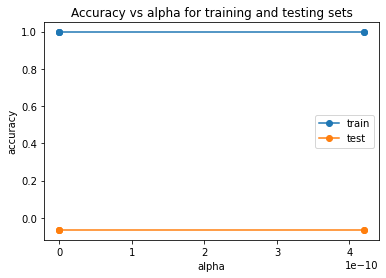

In [14]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
print(train_scores)
print(test_scores)

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# TODO: perform nested cross-validation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

In [ ]:
# Draw tree
clf.get_depth()
plt.figure(figsize=(50,12))
tree.plot_tree(clf,  fontsize=10, feature_names=headers)
plt.show()